In [51]:
import os
import re
import json
import warnings
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


import pickle
import scipy.sparse as sp

warnings.filterwarnings("ignore")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
DATA_PATH = "/mnt/data/fake_job_postings.csv"


In [52]:
import zipfile

zip_path = "archive (1).zip"   # name exactly as shown
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(".")          # extract in current directory

print("Extracted files:", z.namelist())


Extracted files: ['fake_job_postings.csv']


In [53]:

nltk_packages = ['punkt', 'stopwords', 'wordnet', 'omw-1.4']
for pkg in nltk_packages:
    try:
        nltk.data.find(f'tokenizers/{pkg}') if pkg == 'punkt' else nltk.data.find(f'corpora/{pkg}')
    except Exception:
        nltk.download(pkg, quiet=True)

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))


custom_stop_words = {
    'job','work','company','position','apply','experience',
    'candidate','role','opportunity','team','looking'
}
stop_words.update(custom_stop_words)
print(f"Stopwords loaded: {len(stop_words)} words")


Stopwords loaded: 209 words


In [54]:
DATA_PATH = "fake_job_postings.csv"

import os
import pandas as pd

print("Exists:", os.path.exists(DATA_PATH))
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()




Exists: True
Shape: (17880, 18)
Columns: ['job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [55]:

df = df.copy()
df.fillna("", inplace=True)


candidate_text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']
text_cols = [c for c in candidate_text_cols if c in df.columns]
if not text_cols:
    text_cols = [c for c in df.columns if df[c].dtype == 'object']

print("Text columns used:", text_cols)

df['combined_text_raw'] = df[text_cols].agg(' '.join, axis=1).astype(str)
df['combined_text_raw'] = df['combined_text_raw'].str.replace(r'\s+', ' ', regex=True).str.strip()
print("Sample combined text (truncated):")
display(df['combined_text_raw'].head(2))



Text columns used: ['title', 'company_profile', 'description', 'requirements', 'benefits']
Sample combined text (truncated):


0    Marketing Intern We're Food52, and we've creat...
1    Customer Service - Cloud Video Production 90 S...
Name: combined_text_raw, dtype: object

In [56]:
def clean_and_lemmatize(text):
    if not isinstance(text, str) or text.strip() == "":
        return ""
    
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'http\S+|www\.\S+|[\w\.-]+@[\w\.-]+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)

print("Cleaning test:", clean_and_lemmatize("Apply now!!! Visit http://example.com <b>Great</b> job. email@company.com"))


Cleaning test: visit great


In [57]:
print("Applying cleaning to combined_text_raw...")
df['cleaned_text'] = df['combined_text_raw'].apply(clean_and_lemmatize)
df['word_count'] = df['cleaned_text'].str.split().apply(lambda x: len(x) if isinstance(x, list) else 0)

print("Before removal: rows =", len(df))
empty_after = (df['cleaned_text'] == '').sum()
print(f"Empty texts after cleaning: {empty_after}")
df = df[df['cleaned_text'] != ''].reset_index(drop=True)
print("After removal: rows =", len(df))

# Quick stats
print("\nWord count stats (cleaned):")
display(df['word_count'].describe())


Applying cleaning to combined_text_raw...
Before removal: rows = 17880
Empty texts after cleaning: 0
After removal: rows = 17880

Word count stats (cleaned):


count    17880.000000
mean       231.654530
std        127.560141
min          2.000000
25%        136.000000
50%        220.000000
75%        304.000000
max       1348.000000
Name: word_count, dtype: float64

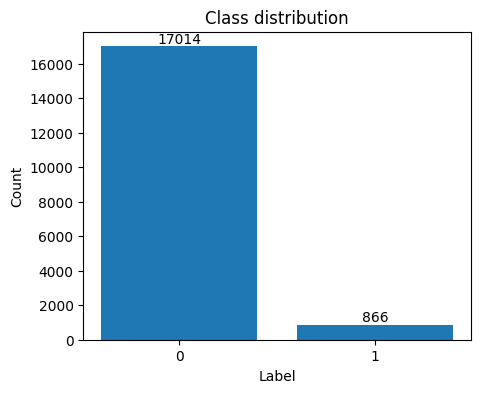


Class percentages:
Label 0: 17014 (95.16%)
Label 1: 866 (4.84%)

Fraction empty (heuristic) for common columns:


salary_range       0.839597
benefits           0.403356
company_profile    0.185011
requirements       0.150783
location           0.019351
title              0.000000
dtype: float64

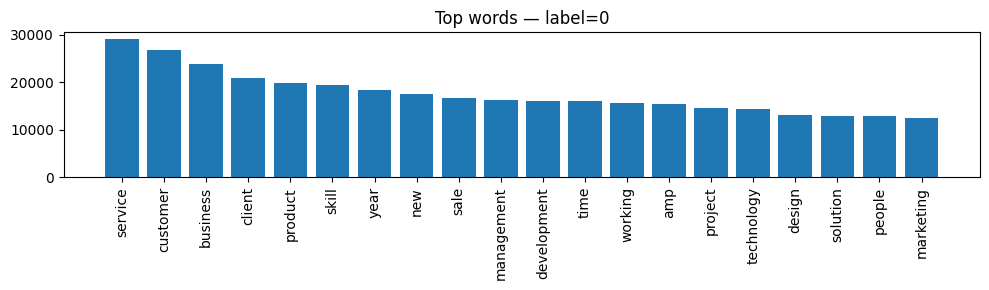

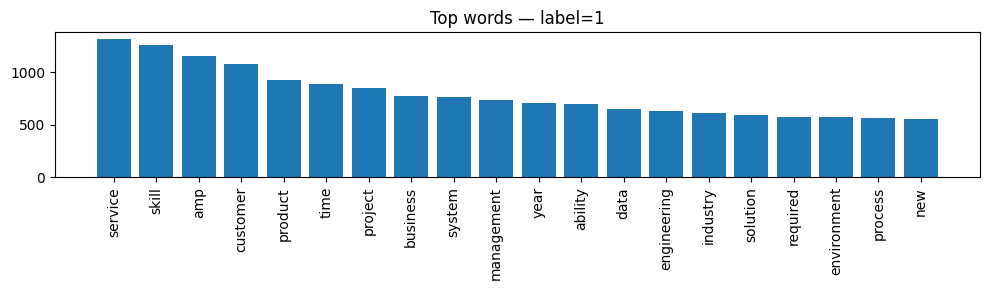

In [58]:
label_candidates = ['fraudulent','is_fraud','label','target']
label_col = next((c for c in label_candidates if c in df.columns), None)
if label_col is None:
    df['fraudulent'] = 0
    label_col = 'fraudulent'
counts = df[label_col].value_counts().sort_index()
plt.figure(figsize=(5,4))
plt.bar([str(i) for i in counts.index], counts.values)
plt.title('Class distribution')
plt.xlabel('Label')
plt.ylabel('Count')
for i, v in enumerate(counts.values):
    plt.text(i, v + max(counts.values)*0.01, str(v), ha='center')
plt.show()
print("\nClass percentages:")
for lbl, cnt in counts.items():
    print(f"Label {lbl}: {cnt} ({cnt/counts.sum():.2%})")

common_cols = [c for c in ['company_profile','salary_range','location','title','benefits','requirements'] if c in df.columns]
if common_cols:
    missing_pct = df[common_cols].apply(lambda col: (col == '').mean()).sort_values(ascending=False)
    print("\nFraction empty (heuristic) for common columns:")
    display(missing_pct)

def top_n_words(texts, n=25):
    words = " ".join(texts).split()
    freq = Counter(words)
    return freq.most_common(n)

overall_top = top_n_words(df['cleaned_text'].tolist(), n=25)
labels = df[label_col].unique()
for lbl in labels:
    top = top_n_words(df[df[label_col]==lbl]['cleaned_text'].tolist(), n=20)
    words, counts = zip(*top) if top else ([],[])
    plt.figure(figsize=(10,3))
    plt.bar(range(len(words)), counts)
    plt.xticks(range(len(words)), words, rotation=90)
    plt.title(f"Top words — label={lbl}")
    plt.tight_layout()
    plt.show()


In [59]:
tfidf_params = dict(
    max_features=3000,       # tuneable
    ngram_range=(1,2),       # unigrams + bigrams
    min_df=2,                # ignore rare terms
    max_df=0.95,             # ignore very common terms
    sublinear_tf=True,
    stop_words=None          # already removed during cleaning; leave None
)

tfidf = TfidfVectorizer(**tfidf_params, token_pattern=r"(?u)\b[a-zA-Z]{2,}\b")
print("Fitting TF-IDF with params:", tfidf_params)
X_tfidf = tfidf.fit_transform(df['cleaned_text'].astype(str).tolist())
print("TF-IDF matrix shape:", X_tfidf.shape)
feature_names = tfidf.get_feature_names_out()
print("Sample features (first 30):", feature_names[:30].tolist())
avg_tfidf = np.array(X_tfidf.mean(axis=0)).ravel()
top_idx = avg_tfidf.argsort()[-20:][::-1]
print("\nTop corpus-level features (by avg tf-idf):")
for i, idx in enumerate(top_idx, 1):
    print(f"{i}. {feature_names[idx]} ({avg_tfidf[idx]:.4f})")


Fitting TF-IDF with params: {'max_features': 3000, 'ngram_range': (1, 2), 'min_df': 2, 'max_df': 0.95, 'sublinear_tf': True, 'stop_words': None}
TF-IDF matrix shape: (17880, 3000)
Sample features (first 30): ['abc', 'ability', 'ability communicate', 'ability effectively', 'ability independently', 'ability manage', 'ability multi', 'able', 'able perform', 'abroad', 'abroad help', 'abroad play', 'academic', 'accept', 'access', 'accessible', 'accommodation', 'accordance', 'according', 'account', 'account executive', 'account management', 'account manager', 'accountability', 'accountable', 'accountant', 'accounting', 'accuracy', 'accurate', 'accurately']

Top corpus-level features (by avg tf-idf):
1. service (0.0286)
2. customer (0.0269)
3. business (0.0260)
4. skill (0.0248)
5. client (0.0244)
6. product (0.0237)
7. year (0.0234)
8. new (0.0228)
9. development (0.0224)
10. time (0.0224)
11. amp (0.0223)
12. working (0.0220)
13. management (0.0219)
14. sale (0.0212)
15. technology (0.0205)

In [60]:
# ===== SAVE TF-IDF VECTORIZER FOR MILESTONE-2 =====
import joblib, os

# Create folder if it doesn't exist
os.makedirs("m1_outputs", exist_ok=True)

# Save the vectorizer
joblib.dump(tfidf, "m1_outputs/tfidf_vectorizer.pkl")

print("✔ TF-IDF Vectorizer saved to: m1_outputs/tfidf_vectorizer.pkl")


✔ TF-IDF Vectorizer saved to: m1_outputs/tfidf_vectorizer.pkl


In [61]:
le = LabelEncoder()
y = le.fit_transform(df[label_col].values)
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

if len(np.unique(y)) > 1:
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)
else:
    X_train, X_test, y_train, y_test = train_test_split(
        X_tfidf, y, test_size=0.2, random_state=RANDOM_SEED)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class counts:", np.bincount(y_train))
print("Test class counts:", np.bincount(y_test))


Label mapping: {np.int64(0): np.int64(0), np.int64(1): np.int64(1)}
Train shape: (14304, 3000) Test shape: (3576, 3000)
Train class counts: [13611   693]
Test class counts: [3403  173]


In [62]:
patterns = {}
for col in ['company_profile','salary_range','location','title','benefits','requirements']:
    if col in df.columns:
        patterns[col] = (df[col] == "").mean()

if patterns:
    print("Fraction empty (heuristic) for common columns:")
    for k,v in patterns.items():
        print(f"  {k}: {v:.2%}")

print("\nSuggested observations for report:")
print("- Note class imbalance and percentages above.")
print("- Compare mean/median word counts between classes.")
print("- Report missingness in company/salary/contact fields if high.")
print("- Mention top words per class (from plots).")


Fraction empty (heuristic) for common columns:
  company_profile: 18.50%
  salary_range: 83.96%
  location: 1.94%
  title: 0.00%
  benefits: 40.34%
  requirements: 15.08%

Suggested observations for report:
- Note class imbalance and percentages above.
- Compare mean/median word counts between classes.
- Report missingness in company/salary/contact fields if high.
- Mention top words per class (from plots).


In [64]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib, os

tfidf_max_features = 5000
tfidf = TfidfVectorizer(
    analyzer='word',
    token_pattern=r"(?u)\b[a-zA-Z]{2,}\b",
    stop_words='english',
    max_features=tfidf_max_features
)

pipeline = Pipeline([('tfidf', tfidf)])
print("Fitting TF-IDF... (may take a moment)")
X_tfidf = pipeline.fit_transform(df['cleaned_text'].astype(str).tolist())
print("TF-IDF matrix shape:", X_tfidf.shape)

feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
print("Sample TF-IDF feature names (first 40):", feature_names[:40].tolist())

# ---- save for Milestone 2 ----
os.makedirs("m1_outputs", exist_ok=True)
joblib.dump(pipeline.named_steps['tfidf'], "m1_outputs/tfidf_vectorizer.pkl")
print("✔ TF-IDF saved in m1_outputs/tfidf_vectorizer.pkl")

Fitting TF-IDF... (may take a moment)
TF-IDF matrix shape: (17880, 5000)
Sample TF-IDF feature names (first 40): ['aaa', 'aabbf', 'aad', 'aan', 'abb', 'abc', 'abfceafd', 'ability', 'able', 'abreast', 'abroad', 'absence', 'absolute', 'absolutely', 'abstract', 'academic', 'academy', 'acc', 'accelerate', 'accelerator', 'accept', 'acceptable', 'acceptance', 'accepted', 'accepting', 'access', 'accessibility', 'accessible', 'accessory', 'accident', 'accion', 'accommodate', 'accommodation', 'accommodationswillingness', 'accomplish', 'accomplished', 'accomplishing', 'accomplishment', 'accordance', 'according']
✔ TF-IDF saved in m1_outputs/tfidf_vectorizer.pkl


In [91]:
print(df.columns)


Index(['model', 'accuracy', 'precision', 'recall', 'f1', 'auc'], dtype='object')


In [66]:
out_clean_csv = "cleaned_fake_jobs.csv"
df.to_csv(out_clean_csv, index=False)
print("Saved cleaned CSV to:", out_clean_csv)

out_tfidf_npz = "tfidf_matrix.npz"
sp.save_npz(out_tfidf_npz, X_tfidf)
with open("tfidf_feature_names.json", "w", encoding="utf-8") as f:
    json.dump(feature_names.tolist(), f)
print("Saved TF-IDF matrix to:", out_tfidf_npz)
print("Saved TF-IDF feature names to: tfidf_feature_names.json")


Saved cleaned CSV to: cleaned_fake_jobs.csv
Saved TF-IDF matrix to: tfidf_matrix.npz
Saved TF-IDF feature names to: tfidf_feature_names.json


In [67]:
def preprocess_and_vectorize(df_in, text_columns=None, max_features=5000):
    df_local = df_in.copy().fillna("")
    if text_columns is None:
        text_columns = [c for c in df_local.columns if df_local[c].dtype == 'object']
    df_local['combined_text_raw'] = df_local[text_columns].agg(' '.join, axis=1).astype(str)
    df_local['clean_text'] = df_local['combined_text_raw'].apply(clean_text)
    vect = TfidfVectorizer(token_pattern=r"(?u)\b[a-zA-Z]{2,}\b", stop_words='english', max_features=max_features)
    X = vect.fit_transform(df_local['clean_text'].tolist())
    return df_local, vect, X

print("Function preprocess_and_vectorize defined. Use it to reproduce pipeline.")


Function preprocess_and_vectorize defined. Use it to reproduce pipeline.


In [ ]:
#MILESTONE - 2#

In [68]:
import time, json, joblib
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV

# ===== LOAD SPLITS SAVED FROM MILESTONE 1 =====
X_train, X_test, y_train, y_test = joblib.load("m1_outputs/train_test_split.joblib")
print("Loaded train-test split successfully!")


Loaded train-test split successfully!


In [92]:

params = {
    "C": [0.01, 0.1, 1, 10],
    "solver": ["liblinear", "lbfgs"],   
    "penalty": ["l2"]                   
}


logreg = LogisticRegression(
    class_weight="balanced", 
    max_iter=5000
)
print("Starting Hyperparameter Tuning using 5-Fold Cross Validation.")
start = time.time()
grid = GridSearchCV(
    estimator=logreg,
    param_grid=params,
    scoring="f1",      
    cv=5,
    verbose=2,
    n_jobs=-1          
)
grid.fit(X_train, y_train)
end = time.time()
best_lr = grid.best_estimator_
print("Best Logistic Regression Parameters:", grid.best_params_)
print(f"⏱️ Training time: {round(end - start, 2)} seconds")

Starting Hyperparameter Tuning using 5-Fold Cross Validation.
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best Logistic Regression Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
⏱️ Training time: 84.66 seconds


In [93]:

y_prob = best_lr.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

print(" Logistic Regression Test Metrics:")
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


 Logistic Regression Test Metrics:
Accuracy: 0.6468, Precision: 0.0788, Recall: 0.5896, F1: 0.1391, AUC: 0.6534

Confusion Matrix:
 [[2211 1192]
 [  71  102]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.65      0.78      3403
           1       0.08      0.59      0.14       173

    accuracy                           0.65      3576
   macro avg       0.52      0.62      0.46      3576
weighted avg       0.93      0.65      0.75      3576



In [95]:

import os
os.makedirs("m2_outputs", exist_ok=True)


joblib.dump(best_lr, "m2_outputs/logreg_best.joblib")


metrics = {
    "model": "LogisticRegression",
    "best_params": grid.best_params_,
    "training_time_sec": round(end - start, 2),
    "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc,
    "confusion_matrix": cm.tolist()
}

with open("m2_outputs/logreg_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("\nLogistic Regression saved successfully in m2_outputs/")



Logistic Regression saved successfully in m2_outputs/


In [97]:
import os, re, joblib
import pandas as pd
from sklearn.model_selection import train_test_split
DATA_PATH = "fake_job_postings.csv"
TFIDF_PATH = "m1_outputs/tfidf_vectorizer.pkl"
os.makedirs("m2_outputs", exist_ok=True)
print("Loading data from:", DATA_PATH)
df = pd.read_csv(DATA_PATH, low_memory=False)
print(" Loading TF-IDF vectorizer from:", TFIDF_PATH)
tfidf = joblib.load(TFIDF_PATH)

print("Cleaning 'description' column for TF-IDF / Random Forest...")
df["description"] = df["description"].fillna("")
def basic_clean(text):
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', ' ', text)          
    text = re.sub(r'http\S+|www\.\S+', ' ', text) 
    text = re.sub(r'[^a-z\s]', ' ', text)         
    text = re.sub(r'\s+', ' ', text).strip()      
    return text
texts = df["description"].apply(basic_clean)
y_all = df["fraudulent"].astype(int).values
X_all = tfidf.transform(texts)
print(" TF-IDF matrix shape:", X_all.shape)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)
print("Train shape:", X_train_rf.shape, " Test shape:", X_test_rf.shape)

Loading data from: fake_job_postings.csv
 Loading TF-IDF vectorizer from: m1_outputs/tfidf_vectorizer.pkl
Cleaning 'description' column for TF-IDF / Random Forest...
 TF-IDF matrix shape: (17880, 5000)
Train shape: (14304, 5000)  Test shape: (3576, 5000)


In [80]:
import pandas as pd, numpy as np, json, pickle, re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
df = pd.read_csv("fake_job_postings.csv", low_memory=False)
df["description"] = df["description"].fillna("")
def basic_clean(text):
    text = str(text).lower()
    text = re.sub(r'<[^>]+>', ' ', text)          
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)         
    text = re.sub(r'\s+', ' ', text).strip()      
    return text
texts = df["description"].apply(basic_clean).tolist()
labels = df["fraudulent"].astype(int).values
MAX_WORDS, MAX_LEN = 20000, 200
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=MAX_LEN)
# 5) Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, labels, stratify=labels, test_size=0.2, random_state=42
)
print("X shape:", X.shape)
print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

X shape: (17880, 200)
Train shape: (14304, 200)  Test shape: (3576, 200)


In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
model = Sequential([
    Embedding(
        input_dim=MAX_WORDS,   # vocabulary size
        output_dim=128,        # embedding size
        input_length=MAX_LEN   # sequence length
    ),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])
model.build(input_shape=(None, MAX_LEN))
model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 200, 128)            │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,667,137 (10.17 MB)

 Trainable params: 2,667,137 (10.17 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=15,
    batch_size=64,
    callbacks=[es]
)


Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.9384 - loss: 0.2766 - val_accuracy: 0.9664 - val_loss: 0.1184
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 70s 388ms/step - accuracy: 0.9749 - loss: 0.0914 - val_accuracy: 0.9623 - val_loss: 0.1120
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 384ms/step - accuracy: 0.9864 - loss: 0.0469 - val_accuracy: 0.9720 - val_loss: 0.1232
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 84s 396ms/step - accuracy: 0.9959 - loss: 0.0146 - val_accuracy: 0.9664 - val_loss: 0.1610
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 417ms/step - accuracy: 0.9980 - loss: 0.0075 - val_accuracy: 0.9731 - val_loss: 0.1504


In [98]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, confusion_matrix

y_prob = model.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")
auc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

print("BiLSTM Test Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

print("\nConfusion Matrix:\n", cm)


112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step
BiLSTM Test Metrics:
Accuracy: 0.9650
Precision: 0.6600
Recall: 0.5723
F1 Score: 0.6130
AUC: 0.9063

Confusion Matrix:
 [[3352   51]
 [  74   99]]


In [99]:
import pickle, json

model.save("m2_outputs/bilstm_model.keras")
with open("m2_outputs/tokenizer.pkl", "wb") as f:  pickle.dump(tokenizer, f)

metrics = {
    "model": "BiLSTM",
    "accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "auc": auc,
    "confusion_matrix": cm.tolist()
}
with open("m2_outputs/bilstm_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("BiLSTM saved in m2_outputs/")


BiLSTM saved in m2_outputs/


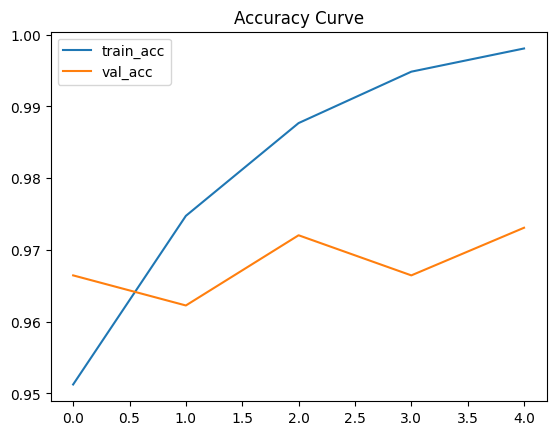

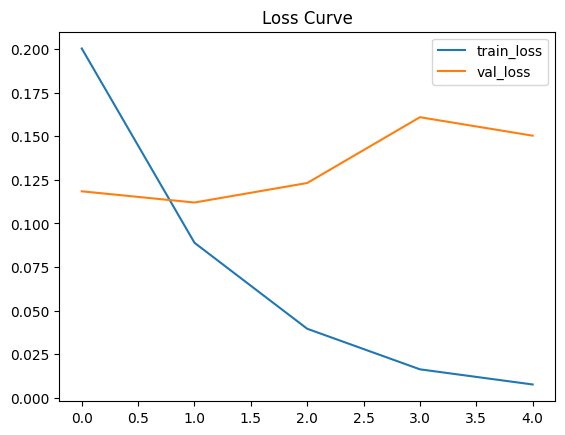

In [87]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend(); plt.title("Accuracy Curve"); plt.show()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss Curve"); plt.show()

In [88]:
import json, pandas as pd

base = "m2_outputs/"

lr  = json.load(open(base+"logreg_metrics.json"))
rf  = json.load(open(base+"random_forest_metrics.json"))
dl  = json.load(open(base+"bilstm_metrics.json"))


In [100]:
df = pd.DataFrame([lr, rf, dl])[["model", "accuracy", "precision", "recall", "f1", "auc"]]
print("MODEL PERFORMANCE COMPARISON:\n")
print(df)

best = df.iloc[df['f1'].idxmax()]
print("BEST MODEL SELECTED:", best["model"])


MODEL PERFORMANCE COMPARISON:

                model  accuracy  precision    recall        f1       auc
0  LogisticRegression  0.974273   0.712042  0.786127  0.747253  0.970679
1        RandomForest  0.977629   0.979381  0.549133  0.703704  0.973010
2              BiLSTM  0.965045   0.660000  0.572254  0.613003  0.906341
BEST MODEL SELECTED: LogisticRegression
